In [1]:

# ~~~~~~~~~~~~~~ Libraries
import sys, os
import mne # Python package for processing and analyzing electrophysiological data
import numpy as np
from glob import glob # look for all the pathnames matching a specified pattern according to the rules
import matplotlib.pyplot as plt
from mne.preprocessing import ICA # ICA (Independent Component Analysis) algorithm, which is for artifact removal
from autoreject import AutoReject # Python package for automatically rejecting bad epochs in EEG/MEG data
import json
import owncloud


In [2]:
# ~~~~~~~~~~~~~~ Environment

# open parent folder of this script
os.chdir('/u/kazma/MINT/code/')

with open("config.json") as f: # The file object is referenced as f during the block.
    config = json.load(f) 
globals().update(config)
sys.path.append(BASE_DIR) # import custom python packages

# import cusom functions
from utils import create_if_not_exist, download_datashare_dir, update_eeg_headers, make_31_montage, calculate_artificial_channels

# get arguments
modality = 'audio'
session = 1
sub_name = 'sub-01_ses-01'
print(f"\n\n Processing {modality} EEG {sub_name} session {session} \n\n")






 Processing audio EEG sub-01_ses-01 session 1 




In [3]:
datashare_dir_path = os.path.join(DATASHARE_RAW_FOLDER, modality, sub_name) #  "DATASHARE_RAW_FOLDER": "MINT/raw/",
# create directories
raw_target_dir_path = os.path.join(BASE_DIR, 'data', 'raw', modality, sub_name)
interim_target_dir_path = os.path.join(BASE_DIR, 'data', 'interim', modality, sub_name)
processed_target_dir_path = os.path.join(BASE_DIR, 'data', 'processed', modality, sub_name)
create_if_not_exist(raw_target_dir_path) 
create_if_not_exist(interim_target_dir_path)
create_if_not_exist(processed_target_dir_path) 
# the interested file name
target_file_name = f"{raw_target_dir_path}/{sub_name}.vhdr"

In [4]:
# ~~~~~~~~~~~~~~ load data from datashare
download_datashare_dir(datashare_dir = datashare_dir_path,
                       target_dir = raw_target_dir_path, 
                       datashare_user = DATASHARE_USER) # "DATASHARE_USER": "kazma",
# get eeg headers from datashare
update_eeg_headers(target_file_name) 

File /u/kazma/MINT/data/raw/audio/sub-01_ses-01/1_audio_2024-10-29_10h43.13.262.csv already exists. Skipping download.
File /u/kazma/MINT/data/raw/audio/sub-01_ses-01/1_audio_2024-10-29_10h43.13.262.log already exists. Skipping download.
File /u/kazma/MINT/data/raw/audio/sub-01_ses-01/1_audio_2024-10-29_10h43.13.262.psydat already exists. Skipping download.
File /u/kazma/MINT/data/raw/audio/sub-01_ses-01/sub-01_ses-01.eeg already exists. Skipping download.
File /u/kazma/MINT/data/raw/audio/sub-01_ses-01/sub-01_ses-01.vhdr already exists. Skipping download.
File /u/kazma/MINT/data/raw/audio/sub-01_ses-01/sub-01_ses-01.vmrk already exists. Skipping download.


In [23]:
# ~~~~~~~~~~~~~~ Load data and the data ajustments
raw = mne.io.read_raw_brainvision(target_file_name,  # Brain vision file format contains three files .vhdr for the header, .eeg for the data, and .vmrk for events
                                  misc='auto', # misc = Specifies that channels labeled as miscellaneous (e.g., auxiliary or non-EEG channels) should be automatically detected.
                                  scale=1.0, # 1.0 means no change for scale
                                  preload=True, # the data is loaded directly into memory. This allows for faster processing 
                                  verbose=False) # Suppresses output during the loading process (helpful when you don’t want too much logging information
raw.rename_channels({'VP': 'Fp2',  # In this case, the channel labeled VP is renamed to Fp2, and VM is renamed to Fp1.
                     'VM': 'Fp1'})
raw.set_montage(make_31_montage(raw))

# Trigger value is converted to condition label name (e.g., from 106 to numerosity 6)
raw.annotations.description = np.array(
    [
        CONDITION_MAP_AUDIO[i] if i in CONDITION_MAP_AUDIO else i
        for i in raw.annotations.description
    ]
)
# interested duration of each trial (e.g., 800ms after the onset of image)
raw.annotations.duration = np.array([POSTSTIM_WINDOW for _ in raw.annotations.description])

# delete remaining stimulus events / This part of the code removes specific types of events from the annotations in the EEG data
indices_to_remove = [i for i, j in enumerate(raw.annotations.description) if "Stimulus" in j or "Segment" in j or "actiCAP" in j]
raw.annotations.delete(indices_to_remove)

# get events (number of events, 3), each row represents [event time, previous_event, event_id]
events, event_id = mne.events_from_annotations(raw, event_id=EVENT_ID)

# resample
raw, events = raw.resample(SFREQ, events = events) # raw.resample(SFREQ, events=events): Resamples the raw EEG data to a new sampling frequency (SFREQ) while adjusting the timing of the events accordingly.

# Extract only the last tone epoch
events_lasttone = []

for num_target in range(1,7):
    # Filter out only the events with condition '4'
    condition_x_events = events[events[:, 2] == num_target]
    idx_vector = np.arange(num_target-1, len(condition_x_events), num_target)
    x = condition_x_events[idx_vector,:]
    events_lasttone.append(x)
events_lasttone = np.vstack(events_lasttone)
# Sort `events_lasttone` based on the values in the first column
events = events_lasttone[np.argsort(events_lasttone[:, 0])]

raw.events = events_lasttone #  This assigns the resampled events back to the raw object, so the events remain associated with the data after resampling.
# ~~~~~~~~~~~~~~ Load data and the data ajustments ~~~~~~~~~~~~~~

Used Annotations descriptions: ['numerosity 1', 'numerosity 2', 'numerosity 3', 'numerosity 4', 'numerosity 5', 'numerosity 6']


numerosity 1 70
numerosity 2 70
numerosity 3 70
numerosity 4 70
numerosity 5 70
numerosity 6 70
Creating RawArray with float64 data, n_channels=1, n_times=327160
    Range : 0 ... 327159 =      0.000 ...   654.318 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=327160
    Range : 0 ... 327159 =      0.000 ...   654.318 secs
Ready.
Overwriting existing file.
Writing /u/kazma/MINT/data/interim/audio/sub-01_ses-01/raw.fif
Closing /u/kazma/MINT/data/interim/audio/sub-01_ses-01/raw.fif
[done]


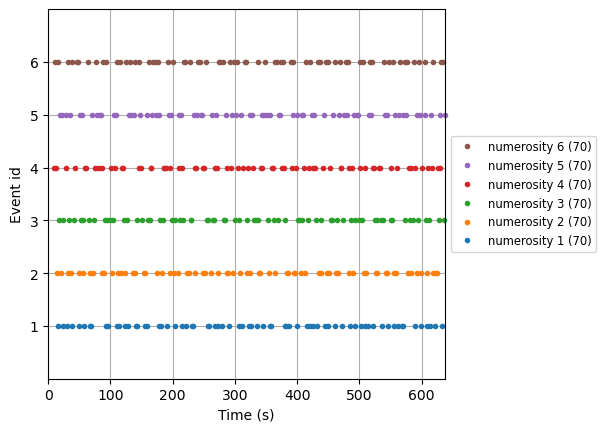

In [24]:
# ~~~~~~~~~~~~~~ print and save
# print the number of trials for each condition
event_counts = {}
for key in EVENT_ID.keys():
    event_counts[key] = len(events[events[:, 2] == EVENT_ID[key]])
    print(key, len(events[events[:, 2] == EVENT_ID[key]]))

# Save event counts in jsonfile
with open(f"{interim_target_dir_path}/event_counts_before_drop.json", "w") as f:
    json.dump(event_counts, f)

# This saves the events and the event ID mapping as .npy (NumPy binary) files for future use.
np.save(f"{interim_target_dir_path}/events.npy", events) # This function saves the array or object
np.save(f"{interim_target_dir_path}/event_id.npy", EVENT_ID)

# This plots the events and saves the visualization as a .png image.
fig = mne.viz.plot_events(events, event_id=EVENT_ID, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, show=False)
fig.savefig(f"{interim_target_dir_path}/events.png")

# creates new artificial channels representing eye movements, using specific EEG channel pairs.
raw = calculate_artificial_channels(raw.copy(), pairs=[['Fp1', 'Fp2'],['F9', 'F10']], labels=['eyeV', 'eyeH']) # ['Fp1', 'Fp2']: These are the frontal electrodes typically used to capture vertical eye movements (denoted as eyeV in this case). ['F9', 'F10']: These electrodes are often placed near the eyes and can be used to capture horizontal eye movements (denoted as eyeH).
# raw.drop_channels(['Fp1']) # former eye channel (dummy name)

# save
raw.save(f"{interim_target_dir_path}/raw.fif", overwrite=True) # .fif file, which is a standard file format used in MNE for storing EEG/MEG data.
# ~~~~~~~~~~~~~~ print and save ~~~~~~~~~~~~~~


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 16501 samples (33.002 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  32 | elapsed:   35.9s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  15 out of  32 | elapsed:   36.0s remaining:   40.8s
[Parallel(n_jobs=-1)]: Done  22 out of  32 | elapsed:   36.1s remaining:   16.4s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:   36.2s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   36.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  32 | elapsed:    6.2s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done  15 out of  32 | elapsed:    7.1s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  22 out of  32 | elapsed:    7.5s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:    7.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    7.9s finished


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 103.1s.
Using EOG channels: eyeV, eyeH
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5000 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Found 2 independent components correlating with EOG signal.


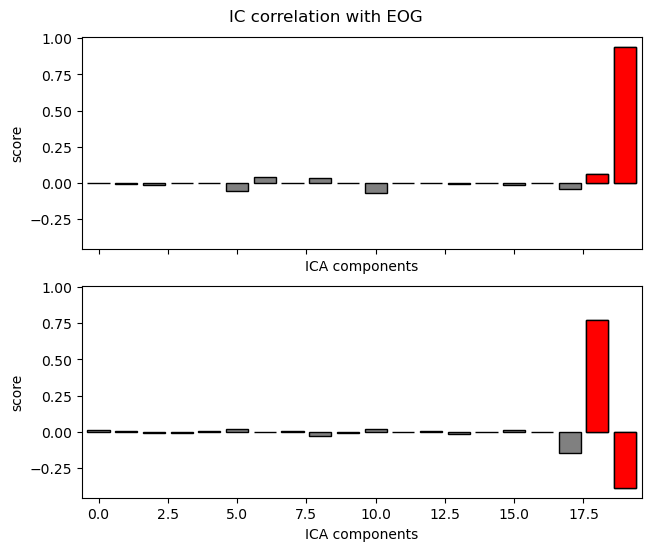

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
327 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
327 matching events found
No baseline correction applied
0 projection items activated
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
420 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 420 events and 551 original time points ...
0 bad epochs dropped


/viper/u/kazma/miniforge3/envs/MINT/lib/python3.9/site-packages/mne/bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
/viper/u/kazma/miniforge3/envs/MINT/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/viper/u/kazma/miniforge3/envs/MINT/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/viper/u/kazma/miniforge3/envs/MINT/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


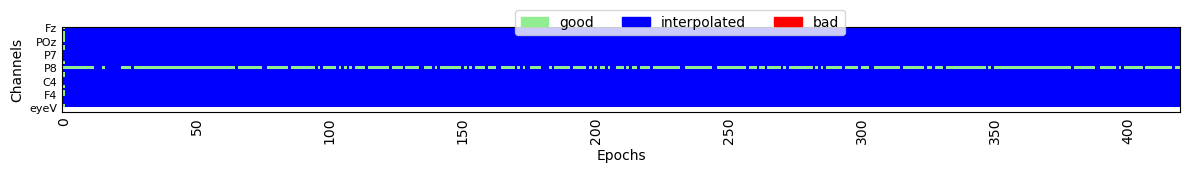

epochs are saved


In [25]:
################################################################################
#################### Preprocessing #############################################
################################################################################

# ~~~~~~~~~~~~~~ band-pass filter
raw.filter(l_freq=PREPROC_PARAMS["hpf"], # high-pass
           h_freq=PREPROC_PARAMS["lpf"], # low-pass
           method='fir', #  Finite Impulse Response (FIR) filter 
           fir_design='firwin', # a popular window method for designing FIR filters
           skip_by_annotation='EDGE boundary', # This skips data points marked by annotations such as "EDGE" or "boundary"
           n_jobs=-1) # This allows the filtering to be done in parallel, using all available CPU cores
# ~~~~~~~~~~~~~~ band-pass filter  ~~~~~~~~~~~~~~



# ~~~~~~~~~~~~~~ eye movement correction
if PREPROC_PARAMS["emc"] == "True":
    filt_raw = raw.copy().filter(l_freq=1.0, h_freq=None, n_jobs=-1)
    
    # ICA model to the filtered EEG data
    ica = ICA(n_components=20, # set the number of ICA to estimate
              max_iter="auto", # Automatically determines the maximum number of iterations for ICA convergence.
              method='picard', # This specifies the ICA algorithm to use. Picard is an efficient ICA algorithm suitable for EEG data.
              random_state=97) # Sets a random seed for reproducibility.
    ica.fit(filt_raw) # bads seem to be ignored by default

    # automatic detection of EOG/EMG components
    ica.exclude = []
    # find which ICs match the EOG pattern
    indices, scores = ica.find_bads_eog(raw)
    print(f'Found {len(indices)} independent components correlating with EOG signal.')
    ica.exclude.extend(indices) # Adds the EOG-correlated ICs to the exclude list. These components will later be removed from the data.

    # barplot of ICA component "EOG/EMG match" scores
    f = ica.plot_scores(scores,
                    title=f'IC correlation with EOG',
                    show=True)
    f.savefig(f"{interim_target_dir_path}/ica_scores.png", dpi=100)

    # plot diagnostics
    if indices: # only if some components were found to correlate with EOG/EMG
        g = ica.plot_properties(raw, 
                                picks=indices, 
                                show=False)
        for gi, p in zip(g, indices):
            gi.savefig(f"{interim_target_dir_path}/ica_diagnostics_ic{p}.png", dpi=100)
    plt.close('all')

    # This applies the ICA solution to the raw EEG data,
    ica.apply(raw)
# ~~~~~~~~~~~~~~ eye movement correction ~~~~~~~~~~~~~~



# ~~~~~~~~~~~~~~ remove eye-movement related channels
channels_to_remove = ['Fp1', 'Fp2']  
raw.drop_channels(channels_to_remove) # former eye channel (dummy name)
# ~~~~~~~~~~~~~~ remove eye-movement related channels ~~~~~~~~~~~~~~



# ~~~~~~~~~~~~~~ reference 
raw.set_eeg_reference(PREPROC_PARAMS["ref"], projection=False) #  average of all electrodes is used as the reference. This indicates that the reference should be applied directly
# ~~~~~~~~~~~~~~ reference ~~~~~~~~~~~~~~


# ~~~~~~~~~~~~~~ epoching
epochs = mne.Epochs(raw, # The continuous EEG data
                    events, # This is an array of events detected in the EEG data
                    event_id=EVENT_ID, #event_id,
                    tmin=PREPROC_PARAMS["base"][0], # the start time = -100ms
                    tmax=PREPROC_PARAMS["tmax"], # The end time of each epoch = 1s
                    baseline=tuple(PREPROC_PARAMS["base"]), # (-100 - 0), Baseline correction subtracts the mean signal in this window from the rest of the epoch to remove slow drifts or offset in the data.
                    detrend=PREPROC_PARAMS["det"], # it removes any linear trends (slow drifts) in the data.
                    proj=False,
                    reject_by_annotation=False, 
                    preload=True)
# ~~~~~~~~~~~~~~ epoching ~~~~~~~~~~~~~~



# ~~~~~~~~~~~~~~  autoreject
if PREPROC_PARAMS["ar"] != "False":
    
    if PREPROC_PARAMS["ar"] == "interpolate":        
        n_interpolate=[len(epochs.info['ch_names'])] # This means the maximum number of channels (equal to the number of channels in the data) will be interpolated, which effectively interpolates all bad channels.
        consensus=[len(epochs.info['ch_names'])]  # Similarly, the consensus parameter is set to match the number of channels
    elif PREPROC_PARAMS["ar"] == "interpolate_reject":    
        n_interpolate = [4, 8, 12, 16]
        consensus = np.linspace(0, 1.0, 11)
    else:
        print("ERROR: No valid AR method provided in config.json, exiting!")
        sys.exit(1)
    
    # automated estimation of rejection threshold based on channel and trial per participant
    ar = AutoReject(n_interpolate=n_interpolate, # The number of channels to interpolate if they are detected as noisy.
                    consensus=consensus, # The proportion of channels that must agree to mark a trial as noisy.
                    random_state=11, # Ensures the results are reproducible by setting the random seed
                    n_jobs=-1, 
                    verbose=False) # Suppresses the printing of verbose output.
    ar.fit(epochs)  # The autoreject algorithm is fitted to the epochs, analyzing the data to determine which trials or channels are noisy.
    epochs, reject_log = ar.transform(epochs.copy(), return_log=True) # epochs = The cleaned EEG epochs after autoreject has been applied. reject_log = A log of which trials were rejected or which channels were interpolated.

    # plot the rejection log and save plot
    rej_plot = reject_log.plot('horizontal', show=True)
    rej_plot.savefig(f"{interim_target_dir_path}/autoreject.png", dpi=100)
    reject_log.save(f"{interim_target_dir_path}/autoreject.npz", overwrite=True) # must end with .npz, compressed numpy file format
# ~~~~~~~~~~~~~~  autoreject  ~~~~~~~~~~~~~~ 


# ~~~~~~~~~~~~~~ delete surplus trials: SKIP


# ~~~~~~~~~~~~~~ save epochs
epochs.save(f"{interim_target_dir_path}/epochs-epo.fif", overwrite=True)
print("epochs are saved")
# ~~~~~~~~~~~~~~save epochs ~~~~~~~~~~~~~~

## Supplements

Reading /viper/u/kazma/MINT/data/interim/audio/sub-01_ses-01/epochs-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
420 matching events found
No baseline correction applied
0 projection items activated


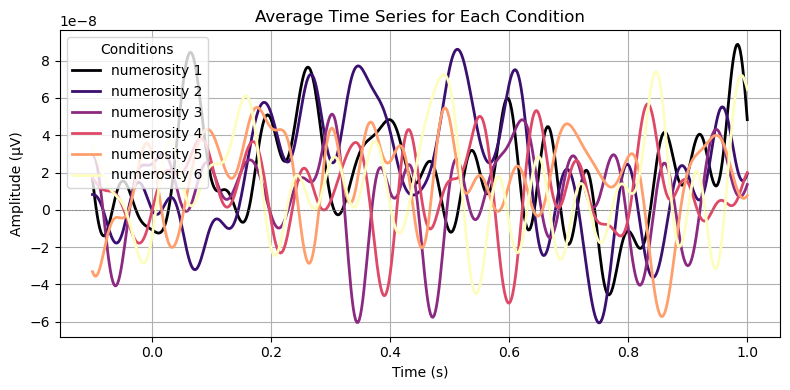

In [26]:
os.chdir('/u/kazma/MINT/data/interim/audio/sub-01_ses-01')

# Replace 'file.fif' with the path to your .fif file
epochs = mne.read_epochs('epochs-epo.fif', preload=True)

condition_names = list(epochs.event_id.keys())
evoked_list = []

for condition in condition_names:
    evoked = epochs[condition].average()  # Average the epochs for the condition
    evoked_list.append(evoked)

# Step 3: Create a single figure and overlay the plots
plt.figure(figsize=(8, 4))

# Set a color map for different conditions
colors = plt.cm.magma(np.linspace(0, 1, len(evoked_list)))

for i, evoked in enumerate(evoked_list):
    # Average across all channels
    avg_data = evoked.data.mean(axis=0)  # Mean across all channels
    times = evoked.times  # Time vector
    
    plt.plot(times, avg_data, label=condition_names[i], color=colors[i], linewidth=2)  # Plot average time series

# Customize the plot
plt.title('Average Time Series for Each Condition')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Add a horizontal line at y=0
plt.legend(title='Conditions')
plt.grid()
plt.tight_layout()
plt.show()
